In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
!pip install transformers datasets evaluate

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import evaluate
import torch

In [ ]:
dataset = load_dataset("MagedSaeed/xlsum_arabic_experimental")
train_data = dataset["train"]
test_data = dataset["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Take subset of the dataset

In [ ]:
train_data = dataset["train"].select(range(10000))
test_data = dataset["test"].select(range(1400))

In [ ]:
columns_to_remove = ["gem_id", "url", "title", "references"]
train_data = train_data.remove_columns(columns_to_remove)
test_data = test_data.remove_columns(columns_to_remove)
print("columns in train_data:", train_data.column_names)
print("columns in test_data:", test_data.column_names)

columns in train_data: ['target', 'text']
columns in test_data: ['target', 'text']


Average text length: 423
Maximum text length: 4618
95% of texts below: 1164

Average summary length: 25
Maximum summary length: 222
95% of summaries below: 42


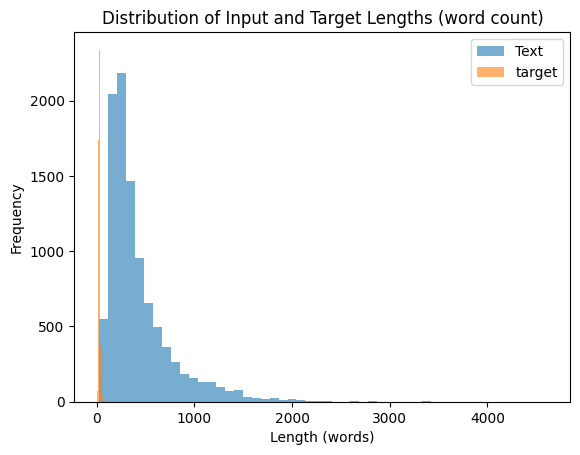

In [ ]:
import matplotlib.pyplot as plt

data = train_data

input_lengths = [len(myData["text"].split()) for myData in data]
target_lengths = [len(myData["target"].split()) for myData in data]

print("Average text length:", sum(input_lengths) // len(input_lengths))
print("Maximum text length:", max(input_lengths))
print("95% of texts below:", sorted(input_lengths)[int(0.95 * len(input_lengths))])

print("\nAverage summary length:", sum(target_lengths) // len(target_lengths))
print("Maximum summary length:", max(target_lengths))
print("95% of summaries below:", sorted(target_lengths)[int(0.95 * len(target_lengths))])

plt.hist(input_lengths, bins=50, alpha=0.6, label='Text')
plt.hist(target_lengths, bins=50, alpha=0.6, label='target')
plt.title("Distribution of Input and Target Lengths (word count)")
plt.xlabel("Length (words)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
mean_input_length = int(np.mean(input_lengths))
mean_target_length = int(np.mean(target_lengths))

print(f"Using max_length {mean_input_length} for Text Input and {mean_target_length} for Target.")


Using max_length 423 for Text Input and 25 for Target.


Load tokenizer and model

In [ ]:
model_name = "ArabicNLP/mT5-base_ar"
print("Loading model and tokenizer...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


Loading model and tokenizer...


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


preprocessing function

In [ ]:
def preprocess_function(examples):
    inputs = tokenizer(examples["text"], max_length=mean_input_length, truncation=True, padding="max_length") # Changed avg_input_length to mean_input_length
    targets = tokenizer(examples["target"], max_length=mean_target_length, truncation=True, padding="max_length") # Changed avg_target_length to mean_target_length
    inputs["labels"] = targets["input_ids"]
    return inputs

In [ ]:

print("Applying preprocessing to dataset...")
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

Applying preprocessing to dataset...


Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

In [ ]:
!pip install rouge_score

In [ ]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    print("\nEvaluation ROUGE scores:", {k: round(v * 100, 4) for k, v in result.items()})
    return {k: round(v * 100, 4) for k, v in result.items()}

In [ ]:
!pip install --upgrade transformers

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./finetuned_mt5_arabic_xlsum",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=5,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=10,
    push_to_hub=False,
    report_to="none"
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-16-32089b685c35>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable:,} / {total:,} ({(trainable/total)*100:.4f}%)")


Trainable parameters: 244,309,248 / 244,309,248 (100.0000%)


In [ ]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,3.387200,2.346630,0.142900,0.071400,0.142900,0.142900
2,3.045900,2.261564,0.214300,0.071400,0.214300,0.214300
3,2.923400,2.213813,0.142900,0.000000,0.142900,0.142900
4,2.675300,2.201056,0.142900,0.000000,0.142900,0.142900



Evaluation ROUGE scores: {'rouge1': np.float64(0.1429), 'rouge2': np.float64(0.0714), 'rougeL': np.float64(0.1429), 'rougeLsum': np.float64(0.1429)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.2143), 'rouge2': np.float64(0.0714), 'rougeL': np.float64(0.2143), 'rougeLsum': np.float64(0.2143)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.1429), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.1429), 'rougeLsum': np.float64(0.1429)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.1429), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.1429), 'rougeLsum': np.float64(0.1429)}


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,3.387200,2.346630,0.142900,0.071400,0.142900,0.142900
2,3.045900,2.261564,0.214300,0.071400,0.214300,0.214300
3,2.923400,2.213813,0.142900,0.000000,0.142900,0.142900
4,2.675300,2.201056,0.142900,0.000000,0.142900,0.142900
5,2.882500,2.190186,0.142900,0.000000,0.142900,0.142900



Evaluation ROUGE scores: {'rouge1': np.float64(0.1429), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.1429), 'rougeLsum': np.float64(0.1429)}


TrainOutput(global_step=7145, training_loss=3.181649993298519, metrics={'train_runtime': 8012.5725, 'train_samples_per_second': 6.24, 'train_steps_per_second': 0.892, 'total_flos': 2.8078970112e+16, 'train_loss': 3.181649993298519, 'epoch': 5.0})

In [ ]:
model.save_pretrained("finetuned_mt5_arabic_xlsum")
tokenizer.save_pretrained("finetuned_mt5_arabic_xlsum")

('finetuned_araT5_xlsum/tokenizer_config.json',
 'finetuned_araT5_xlsum/special_tokens_map.json',
 'finetuned_araT5_xlsum/spiece.model',
 'finetuned_araT5_xlsum/added_tokens.json',
 'finetuned_araT5_xlsum/tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "ArabicNLP/mT5-base_ar"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

text = (
    "في حادثة أثارت الرأي العام، تمكنت شرطة منطقة مكة المكرمة من القبض على عصابة مكونة من خمسة أشخاص،"
    " تورطوا في سلسلة سرقات مسلحة استهدفت محلات الذهب والمجوهرات خلال الأسابيع الماضية. "
    "وأوضحت الجهات الأمنية أن أفراد العصابة كانوا يستخدمون مركبات مسروقة وأسلحة نارية لتنفيذ عملياتهم،"
    " حيث تم رصدهم من خلال كاميرات المراقبة والتحقيقات المكثفة. "
    "وتم ضبط كميات كبيرة من المجوهرات والمبالغ المالية بحوزتهم أثناء مداهمة أحد المنازل التي كانوا يختبئون بها. "
    "وقد أُحيل المتهمون إلى النيابة العامة لاتخاذ الإجراءات النظامية بحقهم."
)

inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)

summary_ids = model.generate(inputs["input_ids"], max_length=180, num_beams=4, early_stopping=True)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# عرض النتيجة
print(" النص الأصلي:")
print(text)
print("\n التلخيص:")
print(summary)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp /content/finetuned_araT5_xlsum/model.safetensors "/content/drive/MyDrive/Colab Notebooks/"


لنزيد عدد الايبوكس لنحسن النتائج و قللت من الليرنينغ ريت

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./finetuned_mt5_arabic_xlsum",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=6,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=10,
    push_to_hub=False,
    report_to="none"
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-18-32089b685c35>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.667800,2.149137,0.261900,0.000000,0.261900,0.238100
2,2.317000,2.023540,0.500000,0.071400,0.500000,0.500000
3,2.017900,1.991755,0.285700,0.000000,0.285700,0.285700
4,1.981300,1.975192,0.547600,0.000000,0.547600,0.523800
5,1.792900,1.983212,0.500000,0.000000,0.500000,0.500000



Evaluation ROUGE scores: {'rouge1': np.float64(0.2619), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.2619), 'rougeLsum': np.float64(0.2381)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.5), 'rouge2': np.float64(0.0714), 'rougeL': np.float64(0.5), 'rougeLsum': np.float64(0.5)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.2857), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.2857), 'rougeLsum': np.float64(0.2857)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.5476), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.5476), 'rougeLsum': np.float64(0.5238)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.5), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.5), 'rougeLsum': np.float64(0.5)}


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.667800,2.149137,0.261900,0.000000,0.261900,0.238100
2,2.317000,2.023540,0.500000,0.071400,0.500000,0.500000
3,2.017900,1.991755,0.285700,0.000000,0.285700,0.285700
4,1.981300,1.975192,0.547600,0.000000,0.547600,0.523800
5,1.792900,1.983212,0.500000,0.000000,0.500000,0.500000
6,1.668700,1.986436,0.571400,0.000000,0.571400,0.571400



Evaluation ROUGE scores: {'rouge1': np.float64(0.5714), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.5714), 'rougeLsum': np.float64(0.5714)}


TrainOutput(global_step=7500, training_loss=2.159463205846151, metrics={'train_runtime': 2481.3169, 'train_samples_per_second': 24.181, 'train_steps_per_second': 3.023, 'total_flos': 3.36947641344e+16, 'train_loss': 2.159463205846151, 'epoch': 6.0})

In [ ]:
model.save_pretrained("finetuned_mt5_arabic_xlsum1")
tokenizer.save_pretrained("finetuned_mt5_arabic_xlsum1")

('finetuned_mt5_arabic_xlsum1/tokenizer_config.json',
 'finetuned_mt5_arabic_xlsum1/special_tokens_map.json',
 'finetuned_mt5_arabic_xlsum1/spiece.model',
 'finetuned_mt5_arabic_xlsum1/added_tokens.json',
 'finetuned_mt5_arabic_xlsum1/tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "./finetuned_mt5_arabic_xlsum"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

mean_input_length = 600
mean_target_length = 128

text = (
    "ألقت الشرطة السورية القبض على ثمانية أشخاص بعد ارتكابهم جريمة قتل لرجل مسن داخل متجره بغرض السرقة، حيث تمت سرقة مبلغ مالي ومحتويات ثمينة من الموقع."
)

inputs = tokenizer(text, return_tensors="pt", max_length=mean_input_length, truncation=True)
summary_ids = model.generate(
    inputs["input_ids"],
    max_length=mean_target_length,
    num_beams=4,
    early_stopping=True
)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("📌 النص الأصلي:")
print(text)
print("\n📝 التلخيص:")
print(summary)

model.save_pretrained("finetuned_mt5_arabic_xlsum1")
tokenizer.save_pretrained("finetuned_mt5_arabic_xlsum1")


📌 النص الأصلي:
ألقت الشرطة السورية القبض على ثمانية أشخاص بعد ارتكابهم جريمة قتل لرجل مسن داخل متجره بغرض السرقة، حيث تمت سرقة مبلغ مالي ومحتويات ثمينة من الموقع.

📝 التلخيص:
ألقت السلطات السورية القبض على ثمانية أشخاص على الأقل بعد ارتكابهم جر


('finetuned_mt5_arabic_xlsum1/tokenizer_config.json',
 'finetuned_mt5_arabic_xlsum1/special_tokens_map.json',
 'finetuned_mt5_arabic_xlsum1/spiece.model',
 'finetuned_mt5_arabic_xlsum1/added_tokens.json',
 'finetuned_mt5_arabic_xlsum1/tokenizer.json')

### increase epochs to 8

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./finetuned_mt5_arabic_xlsum",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=8,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=10,
    push_to_hub=False,
    report_to="none"
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-27-32089b685c35>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.447900,2.072554,0.476200,0.000000,0.476200,0.476200
2,2.157600,2.008183,0.476200,0.071400,0.452400,0.476200
3,1.921400,1.995068,0.714300,0.071400,0.714300,0.714300
4,1.862500,2.005944,0.547600,0.000000,0.523800,0.547600
5,1.713100,2.010070,0.547600,0.000000,0.523800,0.547600
6,1.527000,2.015879,0.619000,0.000000,0.619000,0.619000
7,1.485800,2.044691,0.607100,0.000000,0.607100,0.607100



Evaluation ROUGE scores: {'rouge1': np.float64(0.4762), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.4762), 'rougeLsum': np.float64(0.4762)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.4762), 'rouge2': np.float64(0.0714), 'rougeL': np.float64(0.4524), 'rougeLsum': np.float64(0.4762)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.7143), 'rouge2': np.float64(0.0714), 'rougeL': np.float64(0.7143), 'rougeLsum': np.float64(0.7143)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.5476), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.5238), 'rougeLsum': np.float64(0.5476)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.5476), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.5238), 'rougeLsum': np.float64(0.5476)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.619), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.619), 'rougeLsum': np.float64(0.619)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.6071), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.6071), '

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.447900,2.072554,0.476200,0.000000,0.476200,0.476200
2,2.157600,2.008183,0.476200,0.071400,0.452400,0.476200
3,1.921400,1.995068,0.714300,0.071400,0.714300,0.714300
4,1.862500,2.005944,0.547600,0.000000,0.523800,0.547600
5,1.713100,2.010070,0.547600,0.000000,0.523800,0.547600
6,1.527000,2.015879,0.619000,0.000000,0.619000,0.619000
7,1.485800,2.044691,0.607100,0.000000,0.607100,0.607100
8,1.324400,2.063587,0.464300,0.000000,0.464300,0.428600



Evaluation ROUGE scores: {'rouge1': np.float64(0.4643), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.4643), 'rougeLsum': np.float64(0.4286)}


TrainOutput(global_step=10000, training_loss=1.8420879888534545, metrics={'train_runtime': 3321.8228, 'train_samples_per_second': 24.083, 'train_steps_per_second': 3.01, 'total_flos': 4.49263521792e+16, 'train_loss': 1.8420879888534545, 'epoch': 8.0})

In [ ]:

model.save_pretrained("finetuned_mt5_arabic_xlsum1")
tokenizer.save_pretrained("finetuned_mt5_arabic_xlsum1")


('finetuned_mt5_arabic_xlsum1/tokenizer_config.json',
 'finetuned_mt5_arabic_xlsum1/special_tokens_map.json',
 'finetuned_mt5_arabic_xlsum1/spiece.model',
 'finetuned_mt5_arabic_xlsum1/added_tokens.json',
 'finetuned_mt5_arabic_xlsum1/tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model_path = "finetuned_mt5_arabic_xlsum1"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


mean_input_length = 600
mean_target_length = 128


text = (
    "ألقت الشرطة السورية القبض على ثمانية أشخاص بعد ارتكابهم جريمة قتل لرجل مسن داخل متجره بغرض السرقة، حيث تمت سرقة مبلغ مالي ومحتويات ثمينة من الموقع."
)


inputs = tokenizer(text, return_tensors="pt", max_length=mean_input_length, truncation=True)


summary_ids = model.generate(
    inputs["input_ids"],
    max_length=mean_target_length,
    num_beams=4,
    early_stopping=True
)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)


print("📌 النص الأصلي:")
print(text)
print("\n📝 التلخيص:")
print(summary)

📌 النص الأصلي:
ألقت الشرطة السورية القبض على ثمانية أشخاص بعد ارتكابهم جريمة قتل لرجل مسن داخل متجره بغرض السرقة، حيث تمت سرقة مبلغ مالي ومحتويات ثمينة من الموقع.

📝 التلخيص:
قالت الشرطة السورية إنها ألقت القبض على ثمانية أشخاص بتهمة قتل


### increase epochs to 9

In [ ]:
from transformers import Seq2SeqTrainingArguments, EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    output_dir="./finetuned_mt5_arabic_xlsum",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=9,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=10,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",

)


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]


)

<ipython-input-18-32ff58afe29b>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.660700,2.152754,0.357100,0.000000,0.357100,0.381000
2,2.294500,2.059930,0.285700,0.000000,0.285700,0.285700
3,2.078600,2.011663,0.571400,0.000000,0.571400,0.571400
4,2.010900,1.993557,0.428600,0.071400,0.428600,0.428600



Evaluation ROUGE scores: {'rouge1': np.float64(0.3571), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.3571), 'rougeLsum': np.float64(0.381)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.2857), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.2857), 'rougeLsum': np.float64(0.2857)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.5714), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.5714), 'rougeLsum': np.float64(0.5714)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.4286), 'rouge2': np.float64(0.0714), 'rougeL': np.float64(0.4286), 'rougeLsum': np.float64(0.4286)}


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.660700,2.152754,0.357100,0.000000,0.357100,0.381000
2,2.294500,2.059930,0.285700,0.000000,0.285700,0.285700
3,2.078600,2.011663,0.571400,0.000000,0.571400,0.571400
4,2.010900,1.993557,0.428600,0.071400,0.428600,0.428600
5,1.781500,2.008940,0.357100,0.000000,0.357100,0.357100



Evaluation ROUGE scores: {'rouge1': np.float64(0.3571), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.3571), 'rougeLsum': np.float64(0.3571)}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=6250, training_loss=2.265648246765137, metrics={'train_runtime': 1990.1774, 'train_samples_per_second': 45.222, 'train_steps_per_second': 5.653, 'total_flos': 2.8078970112e+16, 'train_loss': 2.265648246765137, 'epoch': 5.0})

In [ ]:

model.save_pretrained("finetuned_mt5_arabic_xlsum1")
tokenizer.save_pretrained("finetuned_mt5_arabic_xlsum1")


('finetuned_mt5_arabic_xlsum1/tokenizer_config.json',
 'finetuned_mt5_arabic_xlsum1/special_tokens_map.json',
 'finetuned_mt5_arabic_xlsum1/spiece.model',
 'finetuned_mt5_arabic_xlsum1/added_tokens.json',
 'finetuned_mt5_arabic_xlsum1/tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model_path = "finetuned_mt5_arabic_xlsum1"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


mean_input_length = 600
mean_target_length = 128


text = (
    "ألقت الشرطة السورية القبض على ثمانية أشخاص بعد ارتكابهم جريمة قتل لرجل مسن داخل متجره بغرض السرقة، حيث تمت سرقة مبلغ مالي ومحتويات ثمينة من الموقع."
)


inputs = tokenizer(text, return_tensors="pt", max_length=mean_input_length, truncation=True)


summary_ids = model.generate(
    inputs["input_ids"],
    max_length=mean_target_length,
    num_beams=4,
    early_stopping=True
)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)


print("📌 النص الأصلي:")
print(text)
print("\n📝 التلخيص:")
print(summary)

📌 النص الأصلي:
ألقت الشرطة السورية القبض على ثمانية أشخاص بعد ارتكابهم جريمة قتل لرجل مسن داخل متجره بغرض السرقة، حيث تمت سرقة مبلغ مالي ومحتويات ثمينة من الموقع.

📝 التلخيص:
ألقت الشرطة السورية القبض على ثمانية أشخاص بعد ارتكابهم جريمة قتل 


### increase epochs to 10

In [ ]:
from transformers import Seq2SeqTrainingArguments, EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    output_dir="./finetuned_mt5_arabic_xlsum",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=10,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=10,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",

)


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]


)

<ipython-input-23-32ff58afe29b>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.552700,2.131235,0.500000,0.071400,0.500000,0.500000
2,1.372900,2.171633,0.500000,0.000000,0.535700,0.535700



Evaluation ROUGE scores: {'rouge1': np.float64(0.5), 'rouge2': np.float64(0.0714), 'rougeL': np.float64(0.5), 'rougeLsum': np.float64(0.5)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.5), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.5357), 'rougeLsum': np.float64(0.5357)}


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.552700,2.131235,0.500000,0.071400,0.500000,0.500000
2,1.372900,2.171633,0.500000,0.000000,0.535700,0.535700
3,1.540000,2.216932,0.571400,0.000000,0.571400,0.571400
4,1.684600,2.103840,0.428600,0.000000,0.428600,0.428600
5,1.473400,2.115819,0.571400,0.000000,0.571400,0.571400



Evaluation ROUGE scores: {'rouge1': np.float64(0.5714), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.5714), 'rougeLsum': np.float64(0.5714)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.4286), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.4286), 'rougeLsum': np.float64(0.4286)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.5714), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.5714), 'rougeLsum': np.float64(0.5714)}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=6250, training_loss=1.4921040090942383, metrics={'train_runtime': 1999.1364, 'train_samples_per_second': 50.022, 'train_steps_per_second': 6.253, 'total_flos': 2.8078970112e+16, 'train_loss': 1.4921040090942383, 'epoch': 5.0})

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model_path = "finetuned_mt5_arabic_xlsum1"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


mean_input_length = 600
mean_target_length = 128


text = (
    "ألقت الشرطة السورية القبض على ثمانية أشخاص بعد ارتكابهم جريمة قتل لرجل مسن داخل متجره بغرض السرقة، حيث تمت سرقة مبلغ مالي ومحتويات ثمينة من الموقع."
)


inputs = tokenizer(text, return_tensors="pt", max_length=mean_input_length, truncation=True)


summary_ids = model.generate(
    inputs["input_ids"],
    max_length=mean_target_length,
    num_beams=4,
    early_stopping=True
)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)


print("📌 النص الأصلي:")
print(text)
print("\n📝 التلخيص:")
print(summary)

📌 النص الأصلي:
ألقت الشرطة السورية القبض على ثمانية أشخاص بعد ارتكابهم جريمة قتل لرجل مسن داخل متجره بغرض السرقة، حيث تمت سرقة مبلغ مالي ومحتويات ثمينة من الموقع.

📝 التلخيص:
ألقت الشرطة السورية القبض على ثمانية أشخاص بعد ارتكابهم جريمة قتل 
